# Retrievers in LangChain
* Notebook by Adam Lang
* Date: 7/10/2024

# Overview
* We will go over different retriever types that are often implemented using LangChain and Vector Databases. These include but are not limited to:
1. Reranker Retrieval
2. Ensemble Retrieval
3. Hybrid Search Retrieval
4. Contextual Compression Retrieval
5. Parent Document Chunk Retrieval

# Retrievers in LangChain
* LangChain supports API wrappers for all popular vector DBs.
* Allows the user to create retrievers using vector DBs as the foundation.
* Retrievers use a retrieval strategy to retrieve similar documents for user queries.

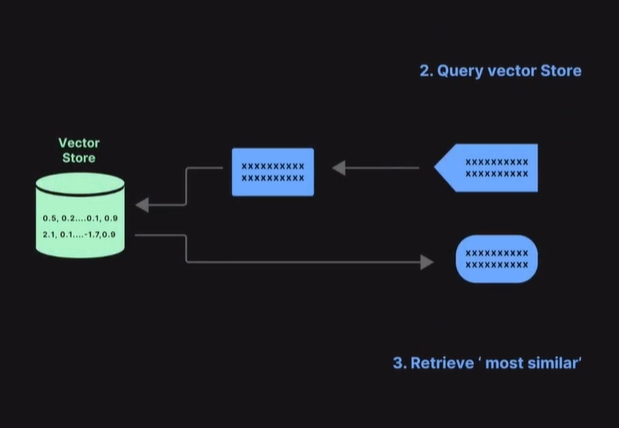

## Popular Retrieval Approaches
* Similarity or ranking based (e.g. cosine similarity)
* Similarity with threshold
  * Example: Give threshold number (3) and only docs with threshold are returned.
* Multi-query Retriever
  * Multiple queries are retrieved and transformed into multiple variants.
  * Sent to Vector DB and retrieve the most relevant docs to send to LLM.
* Reranker Retriever
  * Used at end of multiple retrieval processes.
* Ensemble Retriever
  * Combines multiple retrieval strategies together.

### Similarity or Ranking Based Retrieval
* Similarity metrics drive this mechanism (e.g. cosine, euclidean distance, etc.)

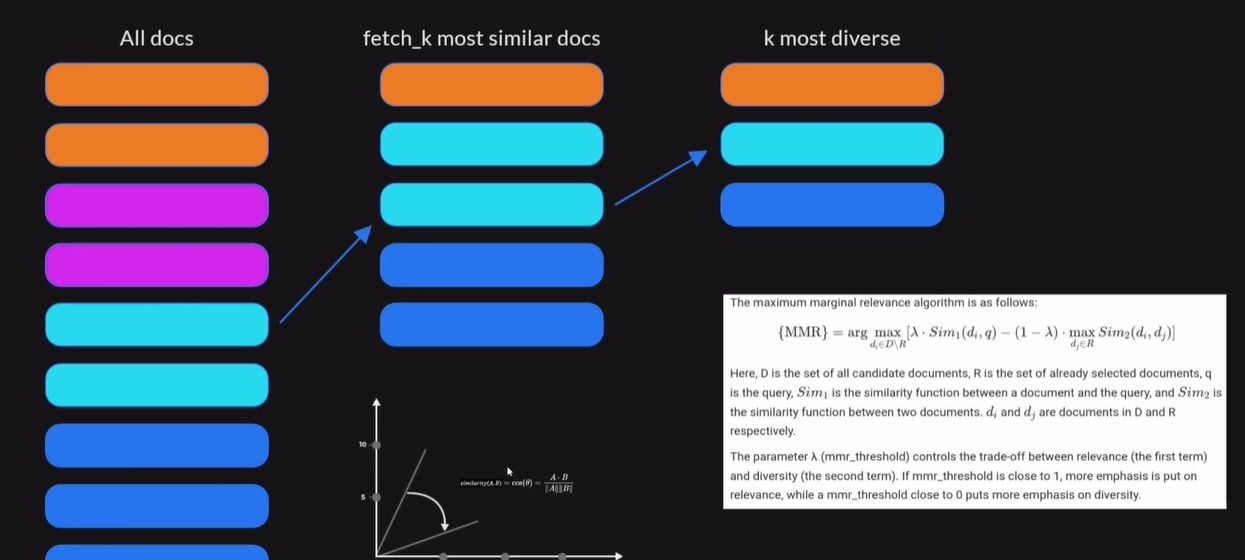

* In addition, as part of this process you can filter your retrieval using metrics such as the MMR (Maximum Marginal Relevance).
   * If threshold closer to 1 --> more emphasis on relevance.
   * If threshold closer to 0 --> more diverse retrieval



### Multi-Query Retrieval
* 1 Query is sent to LLM  --> LLM rephrases query into 3 or more variants --> sent to vector DB --> retrieve most k relevant documents.

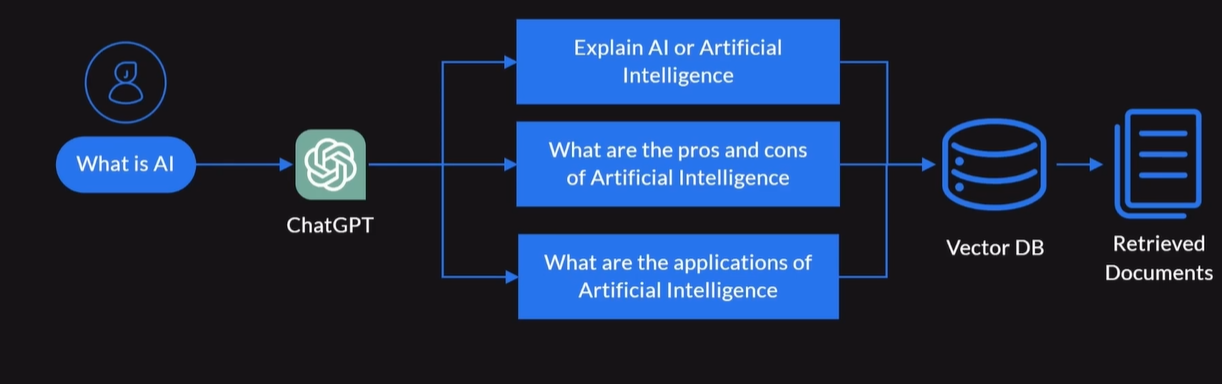

### Self-Query Retrieval
* Query sent to query constructor.
* Query constructor filters this into natural language components.
* Sends to Query Translator in query language then sent to Vector DB.

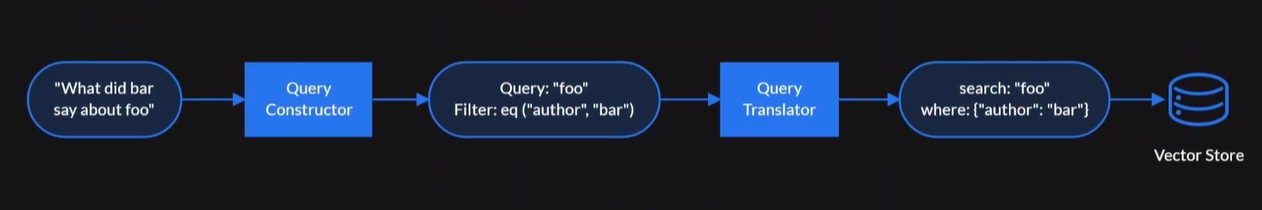

### Reranker Retrieval
* 2 step process
1. Documents are transformed and embedded and computed cosine similarity score is compared to the query separately to find the most relevant documents.
2. Documents are then reranked to find the most relevant similarity scores to the query. This is usually through a transformer cross-encoder which is able to compare the 2 in the same vector space.

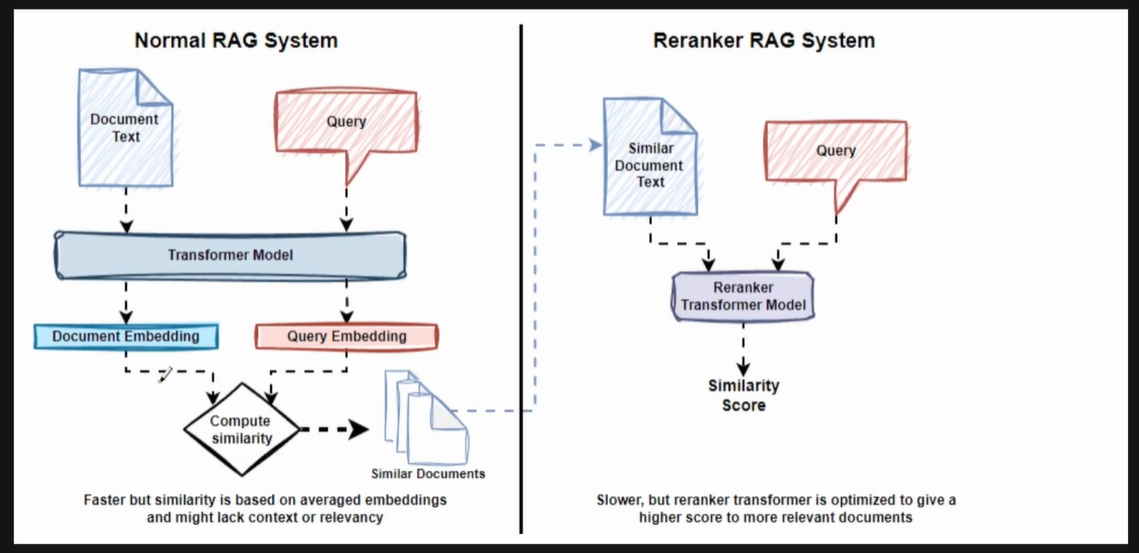

#### When is a reranker most useful?
* There may be more than 1 "correct" answer to a question or query.
* The relevancy of those correct answers or responses though may be ranked based on how relevant they really are in the semantic similarity.
* A re-ranker excels at exactly that.

### Ensemble Retrieval
* Combine multiple retrieval algorithms or processes at the same time (some or all of above and more).
* Weighted average is often taken using a reciprocal rank fusion reranker.
* Documents retrieved.

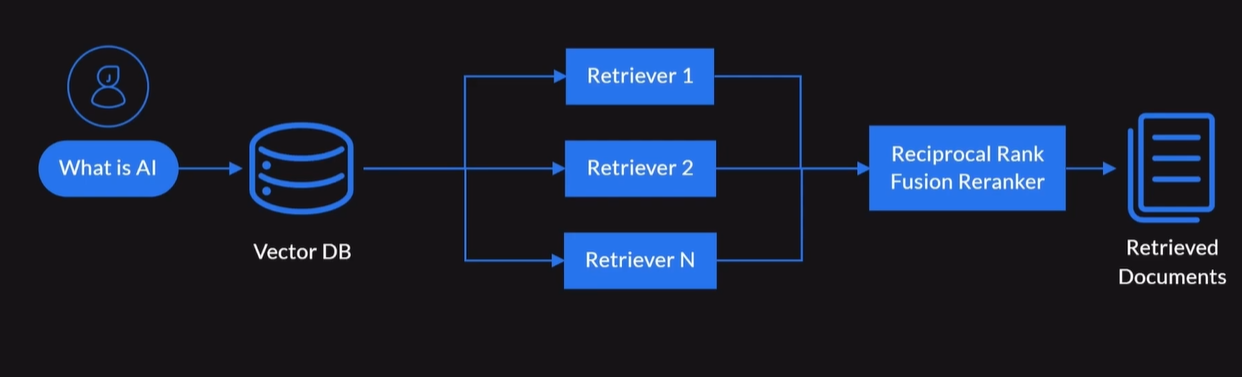

### Hybrid Search Retrieval
* Keyword Search (e.g. TF-IDF, Count Vectorizer, BM25, etc.)
* Semantic Search (e.g. vector embedding retrieval)
* Both used at same time to improve efficiency, speed and quality of results.

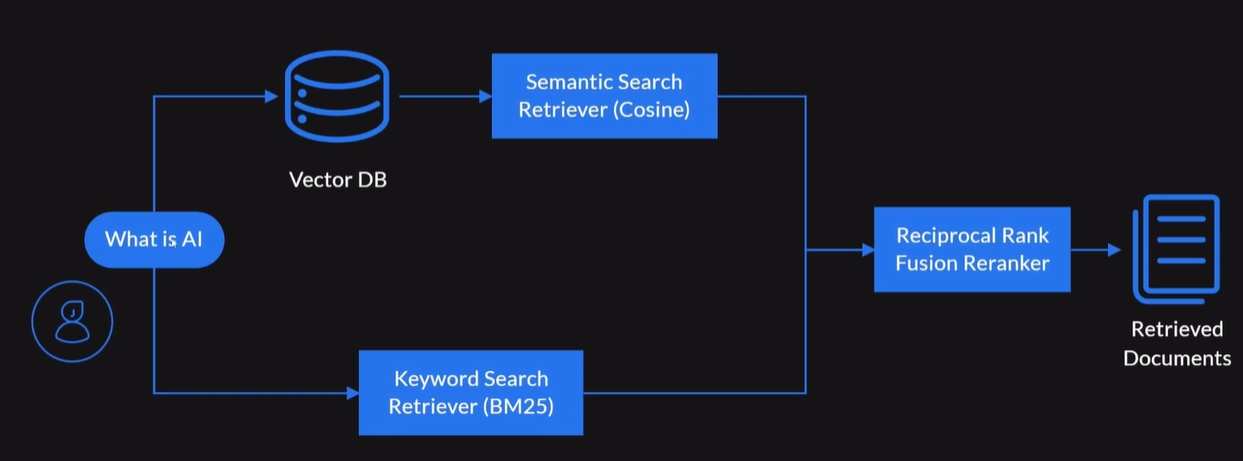

### Contextual Compression Retrieval
* Query sent to Vector DB --> Any retrieval strategy is used --> Sent to Compression Retriever (LLM) --> Most relevant docs returned

### Parent Document Chunk Retrieval
* Hierarchical breakdown of the chunks.
* Parents --> Child --> Vector DB
* Retrieve most relevant chunks from Vector DB
   * The most relevant chunks are retrieved whether they are the child or the parent nodes or both.
   * This is useful to break down the information into entity-relationships.

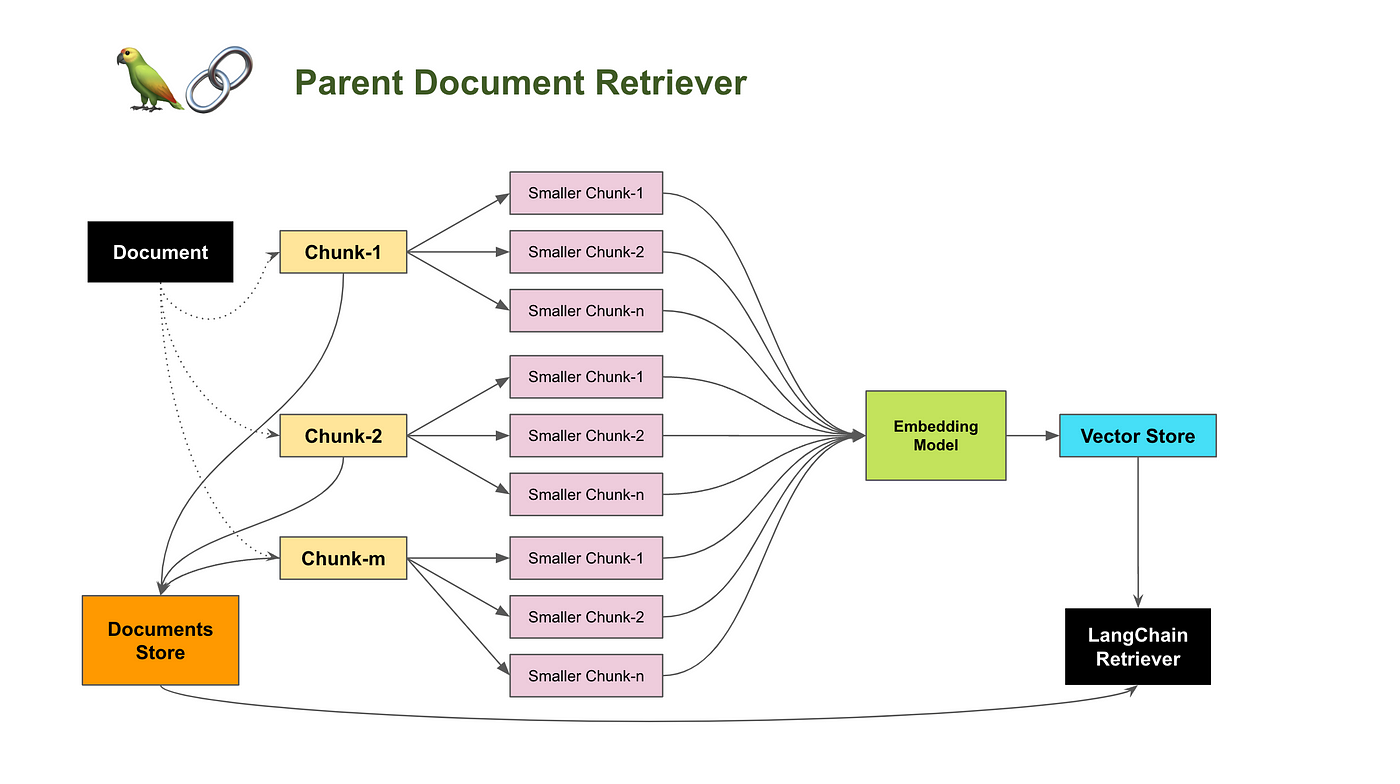

# Experimenting with Various Retrieval Mechanisms in LangChain
* We will implement some of the strategies discussed above.

## Install Dependencies

In [37]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0

### Install Chroma Vector DB and LangChain Wrapper
* Vector Database for our experiments.

In [38]:
!pip install langchain-chroma

### Enter OpenAI API key

In [39]:
from getpass import getpass

OPENAI_KEY = getpass('Please enter your Open AI API key: ')

Please enter your Open AI API key: ··········


### Setting up Environment Variables

In [40]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

### Embedding Models
* You can use any embedding model you want to, but here we will use the OpenAI embeddings via LangChain APIs.

In [41]:
from langchain_openai import OpenAIEmbeddings

# load embedding model
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

### Create Vector Database for Embeddings
* We will use Chroma DB as it is open source and light weight for what we are doing.
* We will use headlines from the Wall Street Journal: https://www.wsj.com/
* I will also include some Word Sense Disambiguation phrases from this repo: https://github.com/danlou/bert-disambiguation/tree/master/data/CoarseWSD-20

In [82]:
# docs to input to vector DB
docs = [
    'EXCLUSIVE: U.S. Agrees to Ship 500-Pound Bombs to Israel. The Biden administration said the U.S. will soon begin shipping the bombs, ending a two-month pause it had imposed in a bid to reduce civilian casualties in Gaza.',
'Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.',
'Among individual share moves in US premarket trading, Costco Wholesale Corp. climbed more than 3% after hiking its membership fee for the first time since 2017. PepsiCo Inc. slipped after reporting weaker-than-expected revenue.',
'While most pundits expect the hardware kingpin of AI, Nvidia (NASDAQ: NVDA), to increase in value over the coming year, high-water price targets from select Wall Street analysts suggest two other AI stocks could more than double investors money in the coming 12 months and leave Nvidia in the dust.',
'Artificial intelligence (AI) is the dominant theme in the stock market. Many investors are focused on a narrow group of leading AI stocks, like Nvidia, Microsoft, and Amazon. However, they might be overlooking great opportunities at the smaller end of the market.',
'Pelosi Signals Biden Should Re-Examine Staying in Race. The former House speaker indicated President Biden’s political fate remained an open question, while George Clooney, who co-hosted a fundraiser for Biden last month, said the president should step aside.',
'Microsoft Quits OpenAI’s Board Amid Antitrust Scrutiny. The tech giant said it resigned with immediate effect because it believed the ChatGPT maker’s board had gained enough stability.',
'UFC’s Dana White to Speak Right Before Trump at Republican Convention. Donald Trump will accept the GOP nomination at next week’s convention in Milwaukee following a speech from Dana White, chief executive of Ultimate Fighting Championship.',
'Biden, Texas Officials Spar Over Beryl Response as Outages Persist. More than 1.6 million Houston-area residents remain without power in the sweltering heat for a third straight day following the storm.',
'Protests Erupt in France After Leftist Coalition Prevails in French Elections. Protesters clashed with police in Paris after a coalition of leftist parties, the New Popular Front, scored a come-from-behind victory in the French parliamentary elections. ',
'A man was caught trying to smuggle more than 100 live snakes into mainland China by stuffing them into his pants, according to the country’s customs authority. Customs officers in the southern Chinese city of Shenzhen intercepted the man traveling through Futian Port, a checkpoint between Hong Kong and mainland China, the agency said in a statement on Tuesday.',
'Over 45,000 species are now threatened with extinction — 1,000 more than last year — according to an international conservation organization that blames pressures from climate change, invasive species and human activity such as illicit trade and infrastructural expansion. The list now includes 163,040 species, an increase of about 6,000 from last year. Copiapoa cacti, native to Chile’s Atacama coastal desert, the Bornean elephant and the Gran Canaria giant lizard are among the threatened species, IUCN revealed.',
'The bubonic plague is the most common form of the bacterial infection, which spreads naturally among rodents like prairie dogs and rats. There are two other forms of the plague: septicemic plague (which spreads through the whole body) and pneumonic plague (which infects the lungs).',
'In a letter released late Monday night by the presidents physician, Dr. Kevin OConnor, he confirmed that Dr. Kevin Cannard, the Parkinsons expert who visited the White House eight times in an eight-month span, "was the neurological specialist that examined President Biden for each of his annual physicals."',
'midwest federal savings and loan was an american bank headquartered in minneapolis , minnesota .',
'the trail goes east and follows the southern bank of the tar river , then at the confluence of the tar river and green mill run , turns south and follows the western edge of the tributary .',
'the other wing of the museum is located at the empress place building on the north bank of the singapore river .',
'its natural habitat are river , intermittent freshwater marsh , freshwater spring , temperate desert ( including the atacama desert ) , and pond .',
'these mechanical controllers used a lever , spring and a mass and were often energized by compressed air .',
'when the eggs hatch in spring , they start feeding on gooseberries , potato , and other fruit and vegetable .',
'modern bathroom and kitchen taps often use ceramic or plastic surfaces sliding against other spring - loaded ceramic surfaces or plastic washers .',
'design and use an ear being pierced with a piercing gun traditional model the most common design uses a spring that stores potential energy when part of the ear piercing instrument is pulled back .',
'its natural habitat consists of river and freshwater spring , which are threatened by habitat loss .',
'Nvidia (NVDA) shares rose again Wednesday, approaching the record high set last month, as the chipmaker continues to benefit from investor enthusiasm about the companys strong position during the artificial intelligence era.',
'Nvidia shares were up 2.5% at $134.72 in afternoon trading Wednesday, approaching their all-time closing high of $135.58 set on June 18. The stock has gained 172% so far in 2024.',
'The Nasdaq Composite, meanwhile, climbed 1.18% and also hit a new all-time high, while the Dow Jones Industrial Average joined the trend, adding 429.39 points, or 1.09%.',
'Shares of software company Hubspot plunged 12% Wednesday after Bloomberg reported that Google parent Alphabet has shelved plans to buy the company. ',

]

#### Note about Chroma distance function
* Need to set the distance function to cosine otherwise it uses L2 or euclidean distance by default. This may depend on your data. Remember that Cosine Similarity by itself does not include magnitude, only direction.
* https://docs.trychroma.com/guides

In [83]:
from langchain_chroma import Chroma

# create vector DB of docs and embeddings
chroma_db = Chroma.from_texts(texts=docs, collection_name='db_docs',
                              collection_metadata={'hnsw:space': 'cosine'},
                              embedding=openai_embed_model)

# Vector Database Retrievers
* Here we are going to experiment with the various algorithms and mechanisms mentioned above.

## Similarity or Ranking based Retrieval
* We will use cosine similarity here and retrieve the top 3 similar documents based on the input query.
* Documents with the lowest cosine distance will have the highest cosine similarity.

In [84]:
# instantiate retriever
similarity_retriever = chroma_db.as_retriever(search_type='similarity',
                                              search_kwargs={"k": 3})

In [85]:
# query and invoke retriever
query = "Where is the bank?"
top3_docs = similarity_retriever.invoke(query)
top3_docs

[Document(page_content='midwest federal savings and loan was an american bank headquartered in minneapolis , minnesota .'),
 Document(page_content='midwest federal savings and loan was an american bank headquartered in minneapolis , minnesota .'),
 Document(page_content='midwest federal savings and loan was an american bank headquartered in minneapolis , minnesota .')]

Summary:
* We can see that the top 3 hits here were variable, one was about a bank that holds your money, the other 2 were about river banks.

In [86]:
query = "Where does the trail go?"
top3_docs = similarity_retriever.invoke(query)
top3_docs

[Document(page_content='the trail goes east and follows the southern bank of the tar river , then at the confluence of the tar river and green mill run , turns south and follows the western edge of the tributary .'),
 Document(page_content='the trail goes east and follows the southern bank of the tar river , then at the confluence of the tar river and green mill run , turns south and follows the western edge of the tributary .'),
 Document(page_content='the trail goes east and follows the southern bank of the tar river , then at the confluence of the tar river and green mill run , turns south and follows the western edge of the tributary .')]

Summary:
* Now we can see I was very specific with my query and it pulled up the first hit which was the document about the trail and the tar river.

In [87]:
query="Tell me about springs."
top3_docs = similarity_retriever.invoke(query)
top3_docs

[Document(page_content='its natural habitat consists of river and freshwater spring , which are threatened by habitat loss .'),
 Document(page_content='its natural habitat consists of river and freshwater spring , which are threatened by habitat loss .'),
 Document(page_content='its natural habitat consists of river and freshwater spring , which are threatened by habitat loss .')]

Summary:
* My query was not specific enough related to the context of the word "spring", so the top 3 returned were related to spring as a body of water and spring the season of the year.

In [88]:
query = "What is an object that is elastic and stores energy?"
top3_docs = similarity_retriever.invoke(query)
top3_docs

[Document(page_content='design and use an ear being pierced with a piercing gun traditional model the most common design uses a spring that stores potential energy when part of the ear piercing instrument is pulled back .'),
 Document(page_content='design and use an ear being pierced with a piercing gun traditional model the most common design uses a spring that stores potential energy when part of the ear piercing instrument is pulled back .'),
 Document(page_content='design and use an ear being pierced with a piercing gun traditional model the most common design uses a spring that stores potential energy when part of the ear piercing instrument is pulled back .')]

Summary:
* We can see that the semantic search with embeddings understood my question related to the physics of springs and returned the top 3 sentences related to that. These were part of the documents I used for word sense disambiguation.

#### Maximal Marginal Relevance Ranking
* MMR
* Retrieve the top 3 similar documents based on user input query.

In [89]:
# instantiate mmr retriever
mmr_retriever = chroma_db.as_retriever(search_type="mmr",
                                       search_kwargs={"k": 3,
                                                      'fetch_k': 10})

In [90]:
query = "Tell me the latest stock market news."
top3_docs = mmr_retriever.invoke(query)
top3_docs

[Document(page_content='The Nasdaq Composite, meanwhile, climbed 1.18% and also hit a new all-time high, while the Dow Jones Industrial Average joined the trend, adding 429.39 points, or 1.09%.'),
 Document(page_content='Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.'),
 Document(page_content='Nvidia shares were up 2.5% at $134.72 in afternoon trading Wednesday, approaching their all-time closing high of $135.58 set on June 18. The stock has gained 172% so far in 2024.')]

In [91]:
query = "How is the market trending?"
top3_docs = mmr_retriever.invoke(query)
top3_docs

[Document(page_content='Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.'),
 Document(page_content='The Nasdaq Composite, meanwhile, climbed 1.18% and also hit a new all-time high, while the Dow Jones Industrial Average joined the trend, adding 429.39 points, or 1.09%.'),
 Document(page_content='Artificial intelligence (AI) is the dominant theme in the stock market. Many investors are focused on a narrow group of leading AI stocks, like Nvidia, Microsoft, and Amazon. However, they might be overlooking great opportunities at the smaller end of the market.')]

In [92]:
query = "Is it a bear market?"
top3_docs = mmr_retriever.invoke(query)
top3_docs

[Document(page_content='Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.'),
 Document(page_content='Artificial intelligence (AI) is the dominant theme in the stock market. Many investors are focused on a narrow group of leading AI stocks, like Nvidia, Microsoft, and Amazon. However, they might be overlooking great opportunities at the smaller end of the market.'),
 Document(page_content='The Nasdaq Composite, meanwhile, climbed 1.18% and also hit a new all-time high, while the Dow Jones Industrial Average joined the trend, adding 429.39 points, or 1.09%.')]

Summary:
* My query was about a bear market where there are usually market declines of more than 20%.
* The top result did give me relevant information to market gains.

## Similarity with Threshold Retrieval
* We will use cosine similarity and retrieve top 3 documents based on input query and this time use a threshold cutoff to not return any documents which are below that threshold.

In [93]:
similarity_threshold_retriever = chroma_db.as_retriever(search_type='similarity_score_threshold',
                                                        search_kwargs={"k": 3,
                                                                       'score_threshold': 0.3}) # cosine sim set to 0.3 -> sim = 1 - cos dist

In [94]:
## using the queries from above
# query and invoke retriever
query = "Where is the bank?"
top3_docs = similarity_retriever.invoke(query)
top3_docs

[Document(page_content='midwest federal savings and loan was an american bank headquartered in minneapolis , minnesota .'),
 Document(page_content='midwest federal savings and loan was an american bank headquartered in minneapolis , minnesota .'),
 Document(page_content='midwest federal savings and loan was an american bank headquartered in minneapolis , minnesota .')]

In [95]:
query = "Where does the trail go?"
top3_docs = similarity_retriever.invoke(query)
top3_docs

[Document(page_content='the trail goes east and follows the southern bank of the tar river , then at the confluence of the tar river and green mill run , turns south and follows the western edge of the tributary .'),
 Document(page_content='the trail goes east and follows the southern bank of the tar river , then at the confluence of the tar river and green mill run , turns south and follows the western edge of the tributary .'),
 Document(page_content='the trail goes east and follows the southern bank of the tar river , then at the confluence of the tar river and green mill run , turns south and follows the western edge of the tributary .')]

In [96]:
query="Tell me about springs."
top3_docs = similarity_retriever.invoke(query)
top3_docs

[Document(page_content='its natural habitat consists of river and freshwater spring , which are threatened by habitat loss .'),
 Document(page_content='its natural habitat consists of river and freshwater spring , which are threatened by habitat loss .'),
 Document(page_content='its natural habitat consists of river and freshwater spring , which are threatened by habitat loss .')]

In [97]:
query = "What is an object that is elastic and stores energy?"
top3_docs = similarity_retriever.invoke(query)
top3_docs

[Document(page_content='design and use an ear being pierced with a piercing gun traditional model the most common design uses a spring that stores potential energy when part of the ear piercing instrument is pulled back .'),
 Document(page_content='design and use an ear being pierced with a piercing gun traditional model the most common design uses a spring that stores potential energy when part of the ear piercing instrument is pulled back .'),
 Document(page_content='design and use an ear being pierced with a piercing gun traditional model the most common design uses a spring that stores potential energy when part of the ear piercing instrument is pulled back .')]

Summary:
* We can see using the word sense disambiguation documents about banks and springs, that the retreiver using a threshold returned only the most similiar hits with less ambiguity in the search result.

## Custom Retriever with Similarity Scores + Thresholding

Here we will create a custom retriever which will do the following:
1. Retreive documents with cosing distance.
2. Convert to similarity score and apply thresholding.
3. Return `topk` documents above a similarity threshold.

In [98]:
query = "Where is the bank located?"
chroma_db.similarity_search_with_score(query, k=3)

[(Document(page_content='midwest federal savings and loan was an american bank headquartered in minneapolis , minnesota .'),
  0.6603631973266602),
 (Document(page_content='midwest federal savings and loan was an american bank headquartered in minneapolis , minnesota .'),
  0.6603631973266602),
 (Document(page_content='midwest federal savings and loan was an american bank headquartered in minneapolis , minnesota .'),
  0.6605100631713867)]

In [99]:
## select relevance score
chroma_db._select_relevance_score_fn()

<function langchain_core.vectorstores.base.VectorStore._cosine_relevance_score_fn(distance: 'float') -> 'float'>

The chroma `_select_relevance_score_fn()` normalizes the distance to a score on a scal of 0 to 1.

In [100]:
## converts cosine distance to similarity; cosine similarity = 1 - cosine distance
cosine_sim = chroma_db._select_relevance_score_fn()
cosine_sim(0.35375)

0.64625

### Now we can create our own custom retriever
* We can use all of the tools above.

In [101]:
# imports
from typing import List
from langchain_core.documents import Document
from langchain_core.runnables import chain


@chain
def custom_retriever(query: str, topk=3, threshold_score=0.3) -> List[Document]:
    # get similarity converstion function (converts cosine distance to similarity)
    cosine_sim = chroma_db._select_relevance_score_fn()
    # get topk documents with lowest cosine distance
    docs, scores, = zip(*chroma_db.similarity_search_with_score(query, k=topk))
    # list to store docs
    final_docs = []
    for doc, score in zip(docs, scores):
        # convert cosine distance to similarity
        score = cosine_sim(score)
        doc.metadata['score'] = round(score, 3)
        # check if score is above threshold
        if score > threshold_score:
            final_docs.append(doc)


    return final_docs

In [107]:
query = "Tell me about Biden."
top3_docs = custom_retriever.invoke(query, topk=3, threshold_score=0.3)
top3_docs

[Document(metadata={'score': 0.387}, page_content='In a letter released late Monday night by the presidents physician, Dr. Kevin OConnor, he confirmed that Dr. Kevin Cannard, the Parkinsons expert who visited the White House eight times in an eight-month span, "was the neurological specialist that examined President Biden for each of his annual physicals."'),
 Document(metadata={'score': 0.387}, page_content='In a letter released late Monday night by the presidents physician, Dr. Kevin OConnor, he confirmed that Dr. Kevin Cannard, the Parkinsons expert who visited the White House eight times in an eight-month span, "was the neurological specialist that examined President Biden for each of his annual physicals."'),
 Document(metadata={'score': 0.387}, page_content='In a letter released late Monday night by the presidents physician, Dr. Kevin OConnor, he confirmed that Dr. Kevin Cannard, the Parkinsons expert who visited the White House eight times in an eight-month span, "was the neurol

In [108]:
query = "How is the market trending?"
top3_docs = custom_retriever.invoke(query, topk=3, threshold_score=0.3)
top3_docs

[Document(metadata={'score': 0.416}, page_content='Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.'),
 Document(metadata={'score': 0.416}, page_content='Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.'),
 Document(metadata={'score': 0.416}, page_content='Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.')]

In [109]:
query = "How is the market trending?"
top3_docs = custom_retriever.invoke(query, topk=3, threshold_score=0.3)
top3_docs

[Document(metadata={'score': 0.416}, page_content='Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.'),
 Document(metadata={'score': 0.416}, page_content='Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.'),
 Document(metadata={'score': 0.416}, page_content='Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.')]

## Multi Query Retrieval
* Retrieval may give different results with subtle changes in query wording or if the embeddings used don't capture semantics of the data well.
* Prompt engineering/tuning is sometimes done to manually address these issues but can be very tedious!!

The `MultiQueryRetriever` automates the process of prompt tuning by using an LLM to generate multiple queries from different perspectives for a given user input query.
  * For each query, it retrieves a set of relevant documents and takes the unique union across all queries to get a larger set of potentially relevant documents.

In [111]:
# ChatOpenAI import - we need an LLM to produce variants of our question or queries
from langchain_openai import ChatOpenAI

# load model
chatgpt = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0)

Multi Query Retriever Set Up

In [112]:
from langchain.retrievers.multi_query import MultiQueryRetriever
# set logging for the queries
import logging


# setup retriever
similarity_retriever = chroma_db.as_retriever(search_type='similarity',
                                              search_kwargs={"k": 3})

# multi-query retriever
mq_retriever = MultiQueryRetriever.from_llm(
    retriever = similarity_retriever,
    llm = chatgpt

)


logging.basicConfig()
# so we can see what queries are generated by the LLM BEFORE it is set to similarity_retriever
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [113]:
# query 1
query = "How are the markets trending?"
docs = mq_retriever.invoke(query)
docs

INFO:langchain.retrievers.multi_query:Generated queries: ['What is the current trend in the markets?', 'Can you provide an update on the market trends?', 'What direction are the markets moving in right now?']


[Document(page_content='Artificial intelligence (AI) is the dominant theme in the stock market. Many investors are focused on a narrow group of leading AI stocks, like Nvidia, Microsoft, and Amazon. However, they might be overlooking great opportunities at the smaller end of the market.'),
 Document(page_content='Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.')]

In [115]:
# query 2
query = "market update?"
docs = mq_retriever.invoke(query)
docs

INFO:langchain.retrievers.multi_query:Generated queries: ['What is the latest news in the market?', 'Can you provide me with an update on the current market trends?', 'What are the recent developments in the market that I should be aware of?']


[Document(page_content='Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.'),
 Document(page_content='Artificial intelligence (AI) is the dominant theme in the stock market. Many investors are focused on a narrow group of leading AI stocks, like Nvidia, Microsoft, and Amazon. However, they might be overlooking great opportunities at the smaller end of the market.')]

Summary:
* We can see the query is sent to the LLM and transformed into 3 variable queries and then sent to the retriever to get the most relevant documents.

## Contextual Compression Retrieval
* The info most relevant to a users query may be buried deep in a document with a lot of irrelevant noise or text.
* Passing the entire or full document through the application can lead to more expensive LLM API calls and even poorer responses as context will be lost with the context window limits.

Contextual Compression is a mechanism to fix this issue.
* The idea is simple: instead of immediately returning the retrieved documents "as-is", you can compress them using the context of the given query, so that only relevant information is returned.

This compression can happen in 2 different ways:
  1. Remove specific parts of the content of retrieved documents which are not relevant to the query. This is done by extracting only relevant parts of the document to the given query.
  2. Filter out the specific documents which are not relevant to the given query but do not remove content from the document.



### Strategy 1: Remove parts of the document that are not relevant to the input query.
* Below we will wrap our base cosine distance retriever with a `ContextualCompressionRetriever`.
* Then we will add an `LLMChainExtractor` which will iterate over the initially returned docs and extract from each **only the content that is relevant to the query.**

In [117]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

# simple cosine distance based retriever
similarity_retriever = chroma_db.as_retriever(search_type='similarity',
                                              search_kwargs={"k": 3})

# extracts only the content that is relevant to the query from each document using the LLM of choice
compressor = LLMChainExtractor.from_llm(llm=chatgpt)

# retrieves the documents similar to query and then applies the compressor
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=similarity_retriever
)


In [118]:
# query
query = "Where is the bank?"
docs = compression_retriever.invoke(query)
docs

[Document(page_content='minneapolis , minnesota'),
 Document(page_content='minneapolis , minnesota'),
 Document(page_content='minneapolis , minnesota')]

Summary:
* Aha! This is very interesting because we can see how specific the retriever is at answering our query compared to the previous methods.
* Before when I asked this question depending on the algorithm used it may give multiple documents in return, but this time it inferred that I was asking about the document where they describe the location of a bank. What is interesting is that the exercise of word disambiguation may still be a problem if I was instead referring to the river bank.

In [119]:
# query
query = "Who is the Republican nominee?"
docs = compression_retriever.invoke(query)
docs

[Document(page_content='Donald Trump will accept the GOP nomination at next week’s convention in Milwaukee'),
 Document(page_content='Donald Trump will accept the GOP nomination at next week’s convention in Milwaukee'),
 Document(page_content='Donald Trump')]

Summary:
* Again we can see that the irrelevant context was removed from the document and the LLM returned the specific context of the document I was looking for.

### Stragegy 2: Filter out the specific documents which are not relevant to the given query but do not remove content from the document.
* The `LLMChainFilter` is slightly simpler but more robust compressor that uses an LLM chain to decide which of the initially retrieved documents to filter out and which ones to return without manipulating the document contents.

In [120]:
from langchain.retrievers.document_compressors import LLMChainFilter

# decides which of the initially retrieved documents to filter out and which ones to return
_filter = LLMChainFilter.from_llm(llm=chatgpt)

# retrieves the documents similar to query and then applies the filter
compression_retriever = ContextualCompressionRetriever(
    base_compressor = _filter, base_retriever=similarity_retriever
)

In [121]:
# query
query = "How is the market trending?"
docs = compression_retriever.invoke(query)
docs

[Document(page_content='Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.'),
 Document(page_content='Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.'),
 Document(page_content='Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.')]

Summary:
* This time the retriever returned only the most relevant documents not the compressed fragments of text.

In [122]:
# query
query = "How is Biden?"
docs = compression_retriever.invoke(query)
docs

[Document(page_content='Pelosi Signals Biden Should Re-Examine Staying in Race. The former House speaker indicated President Biden’s political fate remained an open question, while George Clooney, who co-hosted a fundraiser for Biden last month, said the president should step aside.'),
 Document(page_content='Pelosi Signals Biden Should Re-Examine Staying in Race. The former House speaker indicated President Biden’s political fate remained an open question, while George Clooney, who co-hosted a fundraiser for Biden last month, said the president should step aside.'),
 Document(page_content='Pelosi Signals Biden Should Re-Examine Staying in Race. The former House speaker indicated President Biden’s political fate remained an open question, while George Clooney, who co-hosted a fundraiser for Biden last month, said the president should step aside.')]

In [127]:
# query
query = "Republican nominee"
docs = compression_retriever.invoke(query)
docs

[Document(page_content='UFC’s Dana White to Speak Right Before Trump at Republican Convention. Donald Trump will accept the GOP nomination at next week’s convention in Milwaukee following a speech from Dana White, chief executive of Ultimate Fighting Championship.'),
 Document(page_content='UFC’s Dana White to Speak Right Before Trump at Republican Convention. Donald Trump will accept the GOP nomination at next week’s convention in Milwaukee following a speech from Dana White, chief executive of Ultimate Fighting Championship.'),
 Document(page_content='UFC’s Dana White to Speak Right Before Trump at Republican Convention. Donald Trump will accept the GOP nomination at next week’s convention in Milwaukee following a speech from Dana White, chief executive of Ultimate Fighting Championship.')]

## Ensemble Retrieval
* The `EnsembleRetriever` takes a list of retrievers as input and ensemble that results of each of their retrievals and reranks the results based on the **Reciprocal Rank Fusion Algorithm**.
  * paper:
  * RRF is a method for combining multiple result sets with different relevance indicators into a single result set.
  * RRF requires no tuning, and the different relevance indicators do not have to be related to each other to achieve high-quality results.
     * reference: https://www.elastic.co/guide/en/elasticsearch/reference/current/rrf.html

In [128]:
from langchain.retrievers import EnsembleRetriever

# simple cosine distance based retriever
similarity_retriever = chroma_db.as_retriever(search_type='similarity',
                                              search_kwargs={'k': 3})

# retrieves the documents similar to query and then applies the filter
compression_retriever = ContextualCompressionRetriever(
    base_compressor=_filter, base_retriever=similarity_retriever
)

# ensemble retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[compression_retriever, similarity_retriever],
    weights=[0.7, 0.3]
)

In [129]:
# query
query = "How are the markets trending?"
docs = ensemble_retriever.invoke(query)
docs

[Document(page_content='Nasdaq, S&P 500 Cruise to Records. The Nasdaq led the advance, climbing 1.2%, while the S&P notched its sixth straight record close, the longest such streak since 2021. The Dow gained more than 400 points.')]

In [131]:
# query
query = "When is spring?"
docs = ensemble_retriever.invoke(query)
docs

[Document(page_content='when the eggs hatch in spring , they start feeding on gooseberries , potato , and other fruit and vegetable .')]